# Basic ESN Usage

Tutorial on using the basic ESN class. Note that this class assumes all data can be pulled into memory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ddc import DataLorenz96

In [2]:
from xesn import ESN, from_zarr

In [3]:
plt.style.use("./xesn.mplstyle")

In [4]:
data = DataLorenz96(system_dimension=6)

In [5]:
esn = ESN(
    n_input=data.system_dimension,
    n_output=data.system_dimension,
    n_reservoir=500,
    input_factor=0.863,
    adjacency_factor=0.713,
    connectedness=5,
    bias=1.76,
    leak_rate=0.874,
    tikhonov_parameter=6.9e-7,
    input_kwargs={
        "normalization": "svd",
        "random_seed": 0,
    },
    adjacency_kwargs={
        "random_seed": 1,
    },
    bias_kwargs={
        "random_seed": 2,
    },
)

In [6]:
esn

ESN
    n_input:                6
    n_output:               6
    n_reservoir:            500
--- 
    connectedness:          5
    bias:                   1.76
    leak_rate:              0.874
    tikhonov_parameter:     6.9e-07
--- 
    Input Matrix:
        factor              0.863
        distribution        uniform
        normalization       svd
        is_sparse           False
        random_seed         0
--- 
    Adjacency Matrix:
        factor              0.713
        density             0.01
        distribution        uniform
        normalization       eig
        is_sparse           True
        format              csr
        random_seed         1

In [7]:
esn.build()

In [8]:
data.generate(n_steps=42_000)
xda = data.to_xda()

In [9]:
%timeit esn.train(xda, batch_size=5_000)

1.84 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
data.generate(n_steps=1_000)
data.generate(n_steps=1_501)

tester = data.to_xda()

In [11]:
xds = esn.test(tester, n_steps=1_000, n_spinup=500)

[Text(0.5, 0, 'Forecast Time (MTU)')]

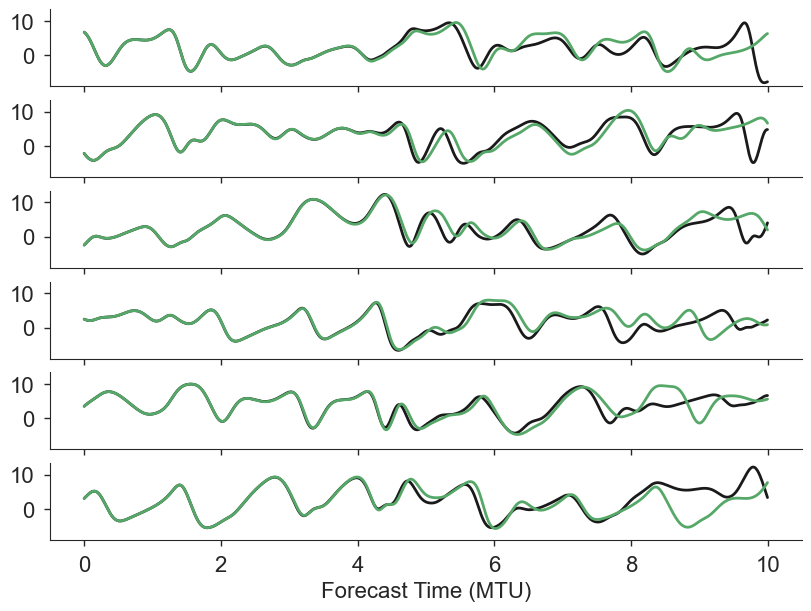

In [12]:
nrows = data.system_dimension
fig, axs = plt.subplots(nrows, 1, figsize=(8, nrows*1), constrained_layout=True, sharex=True, sharey=True)

for i, ax in enumerate(axs):
    xds["truth"].isel(x=i).plot(ax=ax, color="k")
    xds["prediction"].isel(x=i).plot(ax=ax)
    ax.set(ylabel="", xlabel="", title="")
ax.set(xlabel="Forecast Time (MTU)")

## Save and re-load

In [13]:
ds = esn.to_xds()
ds.to_zarr("test.zarr")

In [14]:
esn2 = from_zarr("test.zarr")

In [15]:
y2 = esn2.predict(tester, n_steps=1_000, n_spinup=500)

In [16]:
np.abs(xds["prediction"]-y2).max()

<xarray.DataArray ()>
array(0.)

In [17]:
from shutil import rmtree

In [18]:
rmtree("test.zarr")